# Cuál plan conviene más?

Megaline es una empresa de telefonía que quiere desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de sus planes.

# Contents 

* [Introducción](#introducción)
* [1. Inicialización](#inicializacion)
    * [1.1 Revisión de datos ausentes y duplicados](#ausentes)
    
* [2. Selección de Features y Target](#features)
* [3. Segmentación de datos](#segmentacion)
* [4. Modelos](#modelos)
    * [4.1 Modelo Decision Tree Classifier](#dtc)
    * [4.2 Modelo Random Forest Classifier](#rfc)
    * [4.3 Modelo Logistic Regression](#lr)
    * [4.4 Comparativa de modelos](#comparativo)
* [5. Evaluación de Modelos](#evaluacion)
* [6. Prueba de Cordura](#sanity)
* [7. Conclusiones](#Conclusiones)

<div id="introducción"/>

# Introducción

En este proyecto se busca realizar una tarea de clasificación binaria para crear el mejor modelo (mayor exactitud posible) que determine cual es el plan de comunicación correcto (Ultimate o Surf) a publicitar.

<div id="inicializacion"/>

## Inicialización

In [31]:
#Importación de las librerias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import dump
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

In [32]:
#carga de datos
data = pd.read_csv('/datasets/users_behavior.csv')

In [33]:
# información de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [34]:
#revisión de los datos
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [35]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


De acuerdo a la información estadística se observa que las columnas "calls", "minutes" y "mb_used" tienen la mediana muy cercana a la media, es decir, parecen que estos datos están distribuidos uniformemente, sin embargo, en el caso de "messages" la diferencia se hace un poco más marcada, aquí los datos se deben estar distribuyendo con algún sesgo, porbablemente ocasionados por valores atípicos. 

A continuación daremos un vistazo a la columna "is_ultra" que será el target de nuetsro estudio.

<AxesSubplot:title={'center':'distribución de los planes'}>

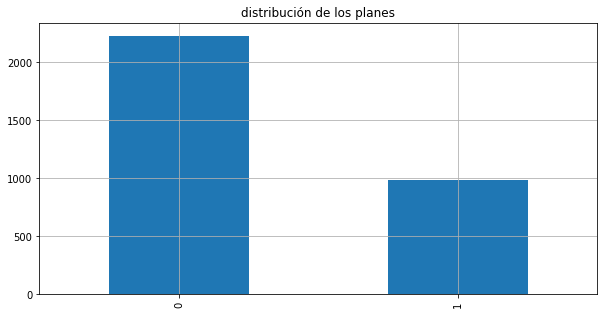

In [36]:
data["is_ultra"].value_counts().plot(kind="bar", grid=True, figsize=(10,5), title="distribución de los planes")

In [37]:
data["is_ultra"].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

La mayor parte de los clientes tienen contratado el plan Surf, aproximadamente el 69%. Este valor nos sirve como punto de partida para al menos exigirle al modelo una exactitud por encima de este valor.

<div id="ausentes"/>

### Revisión de datos ausentes y duplicados

In [38]:
#verificación de valores ausentes
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [39]:
#verificación de duplicados
data.duplicated().sum()

0

Tal como se observa:

1. El DataFrame de estudio, consta de 5 columnas: "calls", "minutes", "messages", "mb_used" y "is_ultra" y 3214 registros.
2. El DataFrame no tiene datos ausentes en sus columnas.
3. El DataFrame no tiene registros duplicados.
4. La columna que será nuestro target es "is_ultra" y es del tipo boleana donde 1 será que tienen el plan Ultimate y 0 el plan Surf.
5. Las otras 4 columnas son numéricas

<div id="features"/>

## Selección de Features y Target

In [40]:
#selección de las características y del objetivo
features = data.drop("is_ultra", axis=1)
target = data["is_ultra"]

<div id="segmentacion"/>

## Segmentación de datos

Se realizará la segmentación de la siguiente manera:
1. 60% para el modelo de entrenamiento
2. Del 40% de los datos totales, se tomará 50% para el modelo de validación y 50% para el modelo de prueba

In [41]:
#segmentación de los datos para entrenamiento 
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.40, random_state=12345)

In [42]:
#segmentación de datos para validación y prueba
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [43]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(1928, 4)
(643, 4)
(643, 4)
(1928,)
(643,)
(643,)


<div id="modelos"/>

## Modelos

En este sección de realizará la evaluación utilizando los siguientes modelos:

1. Decision Tree Classifier
2. Random Forest Classifier
3. Logistic Regression

<div id="dtc"/>

### Modelo Decision Tree Classifier

Se selecciona como hiperparámetro:

max_depth = 20, para evaluar 19 ramas de profundidad en el árbol


In [44]:
best_model = None
best_result_dtc = 0
valid_aprox_dtc = []
max_depth_range = [i for i in range(1, 20)]
for depth in max_depth_range:
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train, target_train)
    
      
    #predicción con datos de validación
    prediction_dtc_valid = model_dtc.predict(features_valid)
    result_dtc_valid = accuracy_score(target_valid, prediction_dtc_valid)
    valid_aprox_dtc.append(result_dtc_valid)
    
    if result_dtc_valid > best_result_dtc:
        best_model = model_dtc
        best_result_dtc = result_dtc_valid
        i = depth
    print("max_depth = ", depth , "exactitud en modelo de validacion:", result_dtc_valid)
    

max_depth =  1 exactitud en modelo de validacion: 0.7542768273716952
max_depth =  2 exactitud en modelo de validacion: 0.7822706065318819
max_depth =  3 exactitud en modelo de validacion: 0.7853810264385692
max_depth =  4 exactitud en modelo de validacion: 0.7791601866251944
max_depth =  5 exactitud en modelo de validacion: 0.7791601866251944
max_depth =  6 exactitud en modelo de validacion: 0.7838258164852255
max_depth =  7 exactitud en modelo de validacion: 0.7822706065318819
max_depth =  8 exactitud en modelo de validacion: 0.7791601866251944
max_depth =  9 exactitud en modelo de validacion: 0.7822706065318819
max_depth =  10 exactitud en modelo de validacion: 0.7744945567651633
max_depth =  11 exactitud en modelo de validacion: 0.7620528771384136
max_depth =  12 exactitud en modelo de validacion: 0.7620528771384136
max_depth =  13 exactitud en modelo de validacion: 0.7558320373250389
max_depth =  14 exactitud en modelo de validacion: 0.7589424572317263
max_depth =  15 exactitud en 

In [45]:
print("La mayor exactitud lograda es de:", best_result_dtc, "en la profundidad de:", i)

La mayor exactitud lograda es de: 0.7853810264385692 en la profundidad de: 3


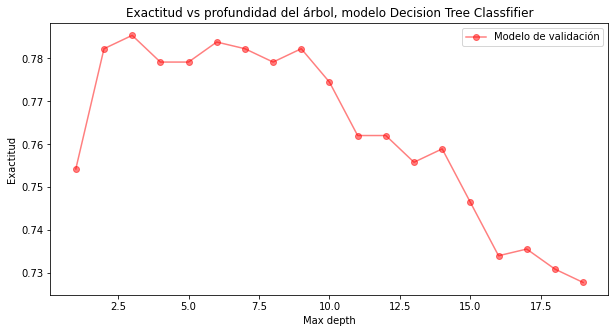

In [46]:
plt.figure(figsize=(10,5))
plt.plot(max_depth_range, valid_aprox_dtc, '-o', color = "red", label = "Modelo de validación", alpha = 0.5)
plt.title("Exactitud vs profundidad del árbol, modelo Decision Tree Classfifier")
plt.xlabel("Max depth")
plt.ylabel("Exactitud")
plt.legend()
plt.show()

Analizando los resultados se observa que a medida que la profundidad crece la exactitud evaluada en el modelo de validación disminuye, ya en la tercera rama se alcanza la mayor exactitud de 78.54%, por lo que se puede ajustar el hiperparámetro a un valor de 4.

<div id="rfc"/>

### Modelo Random Forest Classifier

Se considera como hiperparámetro:
est = 12

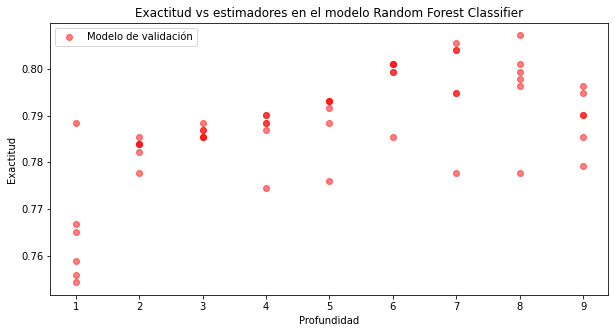

In [47]:
estimator_range = [i for i in range(1, 51, 9)]
#train_aprox_rfc = [] # Log training accuracy scores for the model
valid_aprox_rfc = [] 
depth_list = []
best_model = None
best_result_rfc = 0
i = 0

for est in estimator_range:
    for depth in range(1,10):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(features_train, target_train)
            
        # predicción en modelo de validación
        prediction_rfc_valid = model_rfc.predict(features_valid)
        result_rfc_valid = accuracy_score(target_valid, prediction_rfc_valid)
        valid_aprox_rfc.append(result_rfc_valid)
        depth_list.append(depth)
        
        if result_rfc_valid > best_result_rfc:
            best_model = model_rfc
            best_result_rfc = result_rfc_valid
            j = est
            k = depth
        
        
plt.figure(figsize=(10,5))

plt.plot(depth_list, valid_aprox_rfc, "o", label = "Modelo de validación", color="red", alpha = 0.5)
plt.title("Exactitud vs estimadores en el modelo Random Forest Classifier")
plt.xlabel("Profundidad")
plt.ylabel("Exactitud")
plt.legend()       
       

In [48]:
print("La mayor exactitud lograda es de:", best_result_rfc, "en la estimación:", j, "depth:", k)

La mayor exactitud lograda es de: 0.807153965785381 en la estimación: 46 depth: 8


De los resultados se desprende que a medida que aumenta el número de estimadores se incrementa la exactitud pero la corrida del modelo se hace más lenta. En la profundidad de 8 se observa el mayor valor de exactitud, independiente del estimador.

<div id="lr"/>

### Modelo Logistic Regression

In [49]:
solv = ['liblinear','newton-cg', 'lbfgs','sag', 'saga']
for element in solv:
    model_lr_s = LogisticRegression(random_state=12345, solver=element, max_iter=100000)
    model_lr_s.fit(features_train, target_train)
    predictions_lr_s = model_lr_s.predict(features_valid)
    result_lr_s = accuracy_score(target_valid, predictions_lr_s)
    print("La exactitud es de:", result_lr_s, "con el método:", element)
    

La exactitud es de: 0.7091757387247278 con el método: liblinear
La exactitud es de: 0.7558320373250389 con el método: newton-cg
La exactitud es de: 0.7107309486780715 con el método: lbfgs
La exactitud es de: 0.7076205287713841 con el método: sag
La exactitud es de: 0.7076205287713841 con el método: saga


In [50]:
model_lr = LogisticRegression(random_state=12345, solver="newton-cg")
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
result_lr = accuracy_score(target_valid, predictions_lr)
print("La exactitud es de:", result_lr)

La exactitud es de: 0.7558320373250389


Con este modelo se alcanza una exactitud del 71% (muy por debajo de los valores alcanzados con Decision Tree Classifier y Random Forest Classifier) con los solver de liblinear, lbfgs, sag y saga. Utilizando newton_cg se obtuvo el mayor valor de exactitud, sin embargo, continúa siendo menor al obtenido por otros métodos

<div id="comparativo"/>

### Comparación de Modelos

Se procede a realizar una comparación gráfica entre Decision Tree Classifier, Randon Forest Classifier y Logistic Regression

In [51]:
print("Exactitud modelo Decision Tree Classifier:", best_result_dtc*100)
print("Exactitud modelo Random Forest Classifier:", best_result_rfc*100)
print("Exactitud modelo Logistic Regression:", result_lr*100)

Exactitud modelo Decision Tree Classifier: 78.53810264385692
Exactitud modelo Random Forest Classifier: 80.7153965785381
Exactitud modelo Logistic Regression: 75.58320373250389


De acuerdo a los resultados, el modelo que mejor ajuste muestra es Random Forest Classifier con una exactitud de 81% y el que menos se ajusta es el modelo Logistic Regression.

<div id="evaluacion"/>

## Evaluación del Modelo

Se procederá a evaluar el modelo de entrenamiento (Random Forest Classifier) en el dataset de prueba y en el dataset general.

In [52]:
def eval_modelo(f_train, t_train, f, t, f_test, t_test):
    model_test = RandomForestClassifier(random_state=12345, n_estimators = 46, max_depth=8)
    model_test.fit(f_train, t_train)
    predictions_test = model_test.predict(f_test)
    result_test = accuracy_score(t_test, predictions_test)
    
    model_data = RandomForestClassifier(random_state=12345, n_estimators = 46, max_depth=8)
    model_data.fit(f_train, t_train)
    predictions_data = model_data.predict(f)
    result_data = accuracy_score(t, predictions_data)
    print("Exactitud del modelo Random Forest Classifier en dataset de prueba:", result_test*100)
    print("Exactitud del modelo Random Forest Classifier en dataset completa:", result_data*100)
eval_modelo(features_train, target_train, features, target, features_test, target_test)

Exactitud del modelo Random Forest Classifier en dataset de prueba: 79.62674961119751
Exactitud del modelo Random Forest Classifier en dataset completa: 84.50528935905413


Se observa que evaluando el modelo en el conjunto de datos de prueba la exactitud obtenida es de 80% y al evaluarlo en el dataset completo es de 85%.

<div id="sanity"/>

## Prueba de Cordura (Sanity Check)

In [53]:
strategies = ["most_frequent", "prior", "stratified", "uniform", "constant"]
scores_list = []
for element in strategies:
    if element != "constant":
        sanity_check = DummyClassifier(strategy = element,  random_state = 0)
        sanity_check.fit(features_train, target_train)
        result = sanity_check.score(features_test, target_test)
    else:
        sanity_check = DummyClassifier(strategy = element, random_state = 0, constant =1)
        sanity_check.fit(features_train, target_train)
        result = sanity_check.score(features_test, target_test)

    scores_list.append(result)
scores_list

[0.6842923794712286,
 0.6842923794712286,
 0.5692068429237948,
 0.5303265940902022,
 0.3157076205287714]

Los resultados obtenidos con la prueba de cordura son menores a los conseguidos con los modelos de Random Forest Classifier, Decision Tree Classifier y Logistic Regression.

<div id="conclusiones"/>

## Conclusiones

1. El Dataframe original contiene 5 columnas y 3214 registros.
2. No tiene ni datos ausentes ni datos duplicados.
3. El dataset fue seccionado en 60% para el modelo de entrenamiento y del 40% restante se destinaron 50% para datos de validación y 50% datos de prueba.
4. La exactitud obtenida con el modelo Decision Tree Classifier fue de 78% a una profundidad de 3.
5. La exactitud obtenida con el modelo Random Forest Classifier fue de 81% con un estimador de 46 y profundidad de 8.
6. La exactitud obtenida con el modelo Logistic Regression fue de 75% con newton c-g.
7. Evaluando el modelo Random Forest Classifier en la data de prueba y en el dataset completo se obtuvieron exactitudes de 80% y 85% respectivamente.
7. Con la prueba de cordura la mayor exactitud obtenida fue de 68% (estrategia de "most_frequent" y "prior") y la menor de 53% con las estrategias "uniform" y "constant"